# Response Spectra Calculation and Comparison

In this tutorial we will read in an example record, compute the response
spectra, and compare it to a ground motion prediction equation.


There are a lot of imports to take care of first

In [1]:
import os
import pkg_resources

import matplotlib.pyplot as plt
from matplotlib import _cm as cm
import numpy as np

# OpenQuake imports for GMPEs
from openquake.hazardlib.gsim import base
import openquake.hazardlib.imt as imt
from openquake.hazardlib.const import StdDev
from openquake.hazardlib.gsim.boore_2014 import BooreEtAl2014

from gmprocess.core.streamcollection import StreamCollection
from gmprocess.utils.config import get_config
from gmprocess.waveform_processing.processing import process_streams
from gmprocess.utils.event import get_event_object
from gmprocess.metrics.station_summary import StationSummary

Now we will read in some records from we keep in the repository for testing
purposes, get the config file that controls many of the processing steps,
and the event object for this earthquake

In [2]:
# Path to example data
datapath = os.path.join('data', 'testdata', 'demo', 'ci38457511', 'raw')
datadir = pkg_resources.resource_filename('gmprocess', datapath)
sc = StreamCollection.from_directory(datadir)
sc.describe()

3 StationStreams(s) in StreamCollection:
  3 StationTrace(s) in StationStream (passed):
    CI.CLC.--.HN2 | 2019-07-06T03:16:08.000000Z - 2019-07-06T03:21:27.310000Z | 100.0 Hz, 31932 samples (passed)
    CI.CLC.--.HN1 | 2019-07-06T03:16:08.000000Z - 2019-07-06T03:21:27.310000Z | 100.0 Hz, 31932 samples (passed)
    CI.CLC.--.HNZ | 2019-07-06T03:16:08.000000Z - 2019-07-06T03:21:27.310000Z | 100.0 Hz, 31932 samples (passed)
  3 StationTrace(s) in StationStream (passed):
    CI.TOW2.--.HN2 | 2019-07-06T03:19:31.000000Z - 2019-07-06T03:25:26.390000Z | 100.0 Hz, 35540 samples (passed)
    CI.TOW2.--.HN1 | 2019-07-06T03:19:31.000000Z - 2019-07-06T03:25:26.390000Z | 100.0 Hz, 35540 samples (passed)
    CI.TOW2.--.HNZ | 2019-07-06T03:19:31.000000Z - 2019-07-06T03:25:26.390000Z | 100.0 Hz, 35540 samples (passed)
  3 StationTrace(s) in StationStream (passed):
    CI.CCC.--.HN2 | 2019-07-06T03:19:37.000000Z - 2019-07-06T03:25:31.010000Z | 100.0 Hz, 35402 samples (passed)
    CI.CCC.--.HN1 | 2019

You can see from the output that this test dataset includes 3 StationStreams, 
each with 3 StationTraces. All of the streams are labeled as "passed"
because we have not yet subjected them to the QA tests.

In [3]:
# Get the default config file
conf = get_config()

# Get event object
event = get_event_object('ci38457511')
print(event)

Event:	2019-07-06T03:19:53.040000Z | +35.770, -117.599 | 7.1 mw

	 resource_id: ResourceIdentifier(id="ci38457511")
	        ---------
	     origins: 1 Elements
	  magnitudes: 1 Elements


The next step is to processing the streams and then compute a
"StationSummary" instance, which holds the station and waveform
metrics, including the response spectra

In [4]:
# Process the straems
psc = process_streams(sc, event, conf)
psc.describe()

3 StationStreams(s) in StreamCollection:
  3 StationTrace(s) in StationStream (failed):
    CI.CLC.--.HN2 | 2019-07-06T03:19:52.680000Z - 2019-07-06T03:20:53.210000Z | 100.0 Hz, 6054 samples (passed)
    CI.CLC.--.HN1 | 2019-07-06T03:19:52.680000Z - 2019-07-06T03:20:53.210000Z | 100.0 Hz, 6054 samples (passed)
    CI.CLC.--.HNZ | 2019-07-06T03:19:52.680000Z - 2019-07-06T03:20:53.210000Z | 100.0 Hz, 6054 samples (failed)
  3 StationTrace(s) in StationStream (passed):
    CI.TOW2.--.HN2 | 2019-07-06T03:19:54.060000Z - 2019-07-06T03:21:06.850000Z | 100.0 Hz, 7280 samples (passed)
    CI.TOW2.--.HN1 | 2019-07-06T03:19:54.060000Z - 2019-07-06T03:21:06.850000Z | 100.0 Hz, 7280 samples (passed)
    CI.TOW2.--.HNZ | 2019-07-06T03:19:54.060000Z - 2019-07-06T03:21:06.850000Z | 100.0 Hz, 7280 samples (passed)
  3 StationTrace(s) in StationStream (passed):
    CI.CCC.--.HN2 | 2019-07-06T03:19:57.140000Z - 2019-07-06T03:21:29.800000Z | 100.0 Hz, 9267 samples (passed)
    CI.CCC.--.HN1 | 2019-07-06T

From the `describe` output, you can see that station CI.CLC failed the QA 
checks that are applied during the `process_streams` command. You can also 
see that it is because of a failure on the Z component. To investigate what 
caused the failure, we can look at the `failure` trace parameter

In [5]:
print(psc[0][2].getParameter('failure'))

{'module': 'check_tail', 'reason': 'Velocity ratio is greater than 0.3'}


Note that the first index is to select the CI.CLC stream, and the second is to
select the Z trace.

The output shows that the trace failed in the `check_tail` module with the 
reason being that the tail velocity ratio is great than 0.3. This is a simple
"sanity" check that is designed to avoid records with unphysical drifts. 
Although the record is probably still usable in this case, we will continue
use the third stream (CI.CCC) for the rest of this tutorial.

We compute the response spectral with the StationSummary class

In [6]:
# Compute response spectra for one of the processed streams
summary = StationSummary.from_config(psc[2], event=event, config=conf)
print(summary.pgms)

                            Result
IMT          IMC                  
SA(0.030)    ROTD(50.0)  57.038426
             H2          72.085069
             H1          52.134084
             Z           59.827959
DURATION5-95 H2          11.380000
...                            ...
SA(0.300)    Z           44.512070
SA(1.500)    ROTD(50.0)  41.326347
             H2          20.692151
             H1          53.563236
             Z            8.408986

[101 rows x 1 columns]


The `pgms` attribute is a Pandas dataframe, indexed by the IMTs and IMCs. 

```{note} The "pgm" abbreviation used is this code was originally for 
"peak ground motions". But it now includes ground motion metrics that are
not related to "peaks" in any way (such as duration). So "pgm" may
be better, although more awkwardly, treated as an abbreviation for 
"property of ground motion."
```

We can also get a dictionary that includes the response spectra for a specific
IMC

In [7]:
rotd_dict = summary.get_imc_dict('ROTD(50.0)')

But a more convenient format for plotting is to get the spectral accelerations
and oscillator periods as arrays

In [8]:
sa_arrays = summary.get_sa_arrays('ROTD(50.0)')
period = sa_arrays['ROTD(50.0)']['period']
sa = sa_arrays['ROTD(50.0)']['sa']

# Note on units: OQ uses natural log of g, gmprocess uses %g
sa_g = sa / 100.0

Now we will compute the response spectra from a GMPE

In [9]:
# Prepare inputs for OQ GMPE
gmpe = BooreEtAl2014()
stddev_types = [StdDev.TOTAL]

# Define rupture information
inputs = base.RuptureContext()
inputs.mag = rotd_dict['ROTD(50.0)']['EarthquakeMagnitude']
inputs.rake = 90.0
inputs.hypo_depth = rotd_dict['ROTD(50.0)']['EarthquakeDepth']
inputs.ztor = 0.0
inputs.rjb = np.array([5.0])
inputs.vs30 = np.array([760.0])
inputs.sids = np.array([0])

# Evaluate (must loop over periods since OQ takes in IMT as scalar)
BSSA14 = {
    'lmean': np.array([]),
    'lsd': np.array([])
}
for per in period:
    lmean, lsd = gmpe.get_mean_and_stddevs(
        inputs, inputs, inputs, imt.SA(per), stddev_types)
    BSSA14['lmean'] = np.append(BSSA14['lmean'], lmean[0])
    BSSA14['lsd'] = np.append(BSSA14['lsd'], lsd[0][0])

Lastly, we construct the plot

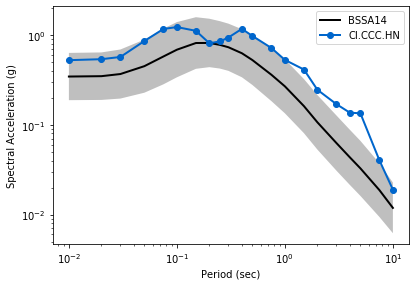

In [10]:
gmpe_mean = np.exp(BSSA14['lmean'])
gmpe_upper = np.exp(BSSA14['lmean'] + BSSA14['lsd'])
gmpe_lower = np.exp(BSSA14['lmean'] - BSSA14['lsd'])
fig = plt.figure()
ax = fig.add_axes([0.125, 0.125, 0.825, 0.825])
ax.fill_between(period, gmpe_lower, gmpe_upper, fc='k', alpha=0.25)
ax.loglog(period, gmpe_mean, color='k', lw=2, label='BSSA14')
ax.loglog(period, sa_g, color=(0.0, 0.4, 0.8), lw=2, marker='o',
          label=psc[2].id)
ax.legend()
ax.set_xlabel('Period (sec)')
ax.set_ylabel('Spectral Acceleration (g)');

% Indices and tables

% ==================

% * :ref:`genindex`

% * :ref:`modindex`

% * :ref:`search`